# Sections:
## 1. S&P Analysis based on market cap for each sector
## 2. Top 4 companies for each sector         
## 3. The impact of each sector and company within the S&P 500

# Project Objective:
## This project's objective is to analyze historical data for the S&P 500 and how each sector can impact the trend of the market. 

# Conclusions:
## After we did our analysis we remarkably find that out of 11 sector only 4 of them effect the market trend with both directions "bearish or bullish".  These 4 sectors control the S&P 500 with 66% of market shares. Information Technology control the market with 27% of market cap, second finance with 14%, followed by Health Care and with Consumer Discretionary 13% followed by Health Care and Consumer Discretionary with 13% of Market cap

In [1]:
# import dependencies
import csv
import calendar
from pprint import pprint

# API Dependencies
import requests
import json

# data science libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#formatting detail for visualizations.
%matplotlib inline
%pylab inline

# Config file keys.  4 will be needed to get around API request limitations
# Alpha Vantage's API call frequency is 5 calls per minute and 500 calls per day for a free account
from config import av_key1 
from config import av_key2
from config import av_key3
from config import av_key4

# create an list of av_keys to use for api scraping
av_key_list = [av_key1 , av_key2 , av_key3 , av_key4]

Populating the interactive namespace from numpy and matplotlib


# Part 1: Sector Analysis
## Based on the state of the market provided by datahub, bellow is an analysis of the top 4 sectors.  Determing which sectors are the largest is fairly trivial, since the sum of the industry market cap will indicate the size of a sector within a particular market.

In [2]:
# Create raw data frame
data_url = "https://datahub.io/core/s-and-p-500-companies-financials/r/constituents-financials.csv"
datahub_df = pd.read_csv(data_url) # raw_df

datahub_df.head()

,Symbol,Name,Sector,Price,Price/Earnings,Dividend Yield,Earnings/Share,52 Week Low,52 Week High,Market Cap,EBITDA,Price/Sales,Price/Book,SEC Filings
0,MMM,3M Company,Industrials,222.89,24.31,2.332862,7.92,259.77,175.490,138721055226,9.048000e+09,4.390271,11.34,http://www.sec.gov/cgi-bin/browse-edgar?action...
1,AOS,A.O. Smith Corp,Industrials,60.24,27.76,1.147959,1.70,68.39,48.925,10783419933,6.010000e+08,3.575483,6.35,http://www.sec.gov/cgi-bin/browse-edgar?action...
2,ABT,Abbott Laboratories,Health Care,56.27,22.51,1.908982,0.26,64.60,42.280,102121042306,5.744000e+09,3.740480,3.19,http://www.sec.gov/cgi-bin/browse-edgar?action...
3,ABBV,AbbVie Inc.,Health Care,108.48,19.41,2.499560,3.29,125.86,60.050,181386347059,1.031000e+10,6.291571,26.14,http://www.sec.gov/cgi-bin/browse-edgar?action...
4,ACN,Accenture plc,Information Technology,150.51,25.47,1.714470,5.44,162.60,114.820,98765855553,5.643228e+09,2.604117,10.62,http://www.sec.gov/cgi-bin/browse-edgar?action...


In [3]:
# Sector Analysis Based Solely on Market Cap

# sector data - discuss sum vs mean for groupby analaysis
sector_df = datahub_df.groupby("Sector").sum() 

# display sectors in decending order of market cap
market_cap_df = sector_df.nlargest(11, 'Market Cap')
display(market_cap_df)

,Price,Price/Earnings,Dividend Yield,Earnings/Share,52 Week Low,52 Week High,Market Cap,EBITDA,Price/Sales,Price/Book
Sector,,,,,,,,,,
Information Technology,8347.00,2602.59,85.994554,217.70,9714.5049,6432.399100,6727121800912,4.313397e+11,411.609970,761.15
Financials,6055.81,1169.53,137.172367,301.71,6923.8857,4943.223800,3442649464852,3.597660e+10,228.356354,458.00
Health Care,8083.46,1406.27,55.951842,264.77,9806.2706,6326.874430,3244359043367,2.231056e+11,294.461598,540.34
Consumer Discretionary,10418.90,2119.49,132.082638,409.84,12342.2399,8071.758553,3213562747315,2.941510e+11,191.164584,2440.66
Industrials,7831.47,1440.12,99.119260,358.05,9016.8249,6086.080600,2411541173034,2.052230e+11,172.417862,605.40
Consumer Staples,2711.98,746.75,82.735293,124.42,3156.2977,2343.601000,2087076388082,1.799275e+11,97.569396,1916.46
Energy,1852.40,1233.89,64.462468,-52.75,2322.8700,1540.519500,1357313712749,1.420450e+11,118.067035,73.20
Materials,2559.67,513.56,43.449399,123.30,2950.9713,2139.581200,692300259151,5.710869e+10,71.902337,119.72
Real Estate,2927.52,741.15,128.527017,78.91,3648.1650,2734.976900,625315677562,4.568073e+10,328.768488,198.16


Text(0.5, 1.0, 'S&P 500 Market Cap')

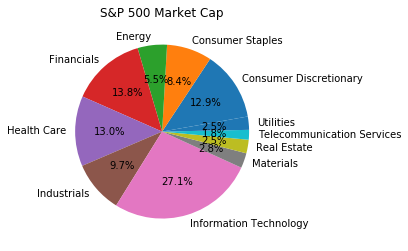

In [4]:
# Figure 1 - Pie chart show make up of each industry 

# create data series
Market_Cap = sector_df["Market Cap"]
Sectors = sector_df.index

# Plot
plt.pie(Market_Cap, labels=Sectors, startangle=10, autopct='%.1f%%')
plt.title('S&P 500 Market Cap')

# Part 2: Company Analysis
## After determining the top sectors, we will determine which companies have the highest market cap within each of the top 4 sectors.

In [5]:
# Sector Analysis:  Top Companies in S and P 500
# this part of the analysis will determine the top 4 companies in each of the top sectors in the S & P 500
# symbols will be a list of lists, with each sector occupying a row.  
# percent_market_cap_per_company and market_cap_value_per_company are also 

# whichever sectors have the highest market cap will be shown following the call below. 
top_4_market_cap_df = sector_df.nlargest(4, 'Market Cap')

# store the top 4 sectors in a list
top_four_sectors_array = top_4_market_cap_df.index

symbols = [] # initialize list to store symbols of the top 4 companies from each sector
percent_market_cap_per_company = [] # initialize a list to show market cap for all 16 companies
market_cap_value_per_company = []
MC_total = sum(datahub_df['Market Cap'])
# loop through each sector to find the top 4 companies
for asector in top_four_sectors_array:
    companies_in_sector_df = datahub_df.loc[datahub_df['Sector'] == asector]
    top_companies_in_sector_df = companies_in_sector_df.nlargest(4, 'Market Cap')  
    symbols.append(top_companies_in_sector_df['Symbol'].tolist()) # append the list to the list symbols
    percent_market_cap_per_company.append(((top_companies_in_sector_df['Market Cap'] / MC_total)*100).tolist())
    market_cap_value_per_company.append((top_companies_in_sector_df['Market Cap'].tolist()))

print(symbols)
print(percent_market_cap_per_company)
print(market_cap_value_per_company)                                    

[['AAPL', 'GOOGL', 'GOOG', 'MSFT'], ['JPM', 'BAC', 'WFC', 'BRK.B'], ['JNJ', 'UNH', 'PFE', 'ABBV'], ['AMZN', 'HD', 'CMCSA', 'DIS']]
[[3.25549256031331, 2.9511238455226834, 2.9298561469124067, 2.7747960187609206], [1.5547933824400662, 1.2928468249539689, 1.1319254225081856, 1.0512430240601554], [1.4198651276270986, 0.8800593326965636, 0.8385194612933191, 0.7294577429461229], [2.7582872249771735, 0.8983326271936019, 0.7499301433828341, 0.6346730823033578]]
[[809508034020, 733823966137, 728535558140, 689978437468], [386613611000, 321478200969, 281463620775, 261401203633], [353062464971, 218834811333, 208505541949, 181386347059], [685873374731, 223378633329, 186476996883, 157817273295]]


Text(0.5, 1.0, 'Percent Market Cap of S&P 500')

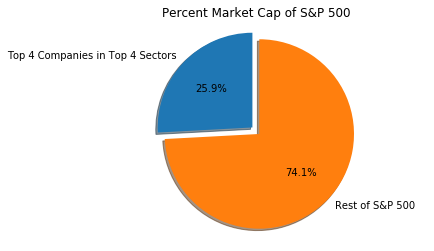

In [6]:
# Figure 2-1 - Shows the make up of the top 16 companies compared to the entire market

# only create 2 slices for simplicity
labels = ["Top 4 Companies in Top 4 Sectors","Rest of S&P 500"]

# create percentages data from percent market cap per company matrix
# find the percentage the rest of the market
analysis_MC_total = sum(percent_market_cap_per_company)
sizes = [analysis_MC_total]
rest_of_s_and_p_MC = 100 - analysis_MC_total
sizes.append(rest_of_s_and_p_MC)
explode = (0.1,0)
# plot
plt.pie(sizes, labels=labels, explode = explode,autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Percent Market Cap of S&P 500")

Text(0.5, 1.0, 'Consumer Discretionary')

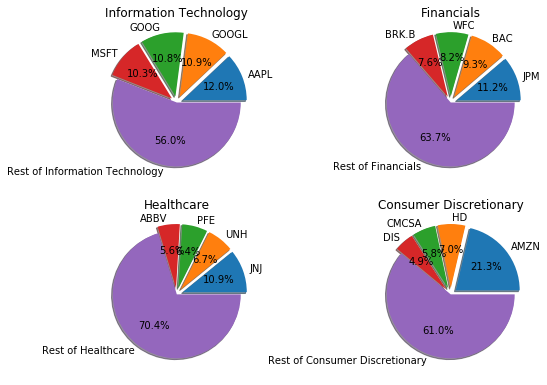

In [7]:
# Figure 2-2 - Shows the make up of the top 4 companies within the individual sector's total market cap

# plot parameters
fig = plt.figure(figsize=(9, 10))
explode = (0.1,0.1,0.1,0.1,0)

# Sector 1
plt.subplot(321)
IT_sub_sector_market_cap = int(top_4_market_cap_df.iloc[0,6])
names = symbols[0]
names.append("Rest of Information Technology")
values = [100*(x/IT_sub_sector_market_cap) for x in market_cap_value_per_company[0]]
sub_sector_sum = sum(values)
values.append(100 - sub_sector_sum)
plt.pie(values,labels = names, autopct='%1.1f%%', shadow = True, explode = explode)
plt.title("Information Technology")

# Sector 2
plt.subplot(322)
Financials_sub_sector_market_cap = int(top_4_market_cap_df.iloc[1,6])
names = symbols[1]
names.append("Rest of Financials")
values = [100*(x/Financials_sub_sector_market_cap) for x in market_cap_value_per_company[1]]
sub_sector_sum = sum(values)
values.append(100 - sub_sector_sum)
plt.pie(values,labels = names, autopct='%1.1f%%', shadow = True, explode = explode)
plt.title("Financials")

# Sector 3
plt.subplot(323)
healtcare_sub_sector_market_cap = int(top_4_market_cap_df.iloc[2,6])
names = symbols[2]
names.append("Rest of Healthcare")
values = [100*(x/healtcare_sub_sector_market_cap) for x in market_cap_value_per_company[2]]
sub_sector_sum = sum(values)
values.append(100 - sub_sector_sum)
plt.pie(values,labels = names, autopct='%1.1f%%', shadow = True, explode = explode)
plt.title("Healthcare")

# Sector 4
plt.subplot(324)
CD_sub_sector_market_cap = int(top_4_market_cap_df.iloc[3,6])
names = symbols[3]
names.append("Rest of Consumer Discretionary")
values = [100*(x/CD_sub_sector_market_cap) for x in market_cap_value_per_company[3]]
sub_sector_sum = sum(values)
values.append(100 - sub_sector_sum)
plt.pie(values,labels = names, autopct='%1.1f%%', shadow = True, explode = explode)
plt.title("Consumer Discretionary")

# Part 3: Impact of Each Sector and Company Within the S&P 500
## Now that we know the top 4 companies in the top 4 sectors, we can collect historical data from alpha vantage and display figures showing the price fluctuation of each stock over time.

In [8]:
# ALPHA VANTAGE API SCRAPING

# will need function, symbol, and api key in order to import the json from the api
url_alpha_vantage = "https://www.alphavantage.co/" 

# url variables
function = "TIME_SERIES_DAILY"
outputsize = "full" # full or compact (100 latest vs all data)

# control variables.  Needed due to API request limitations 
# indices of sector 
i = 1 # sector index control
j = 0 # company index control

# loop through symbols array in order to get json responses from alpha vantage  
json_responses = []
for index in range(len(symbols)):
        query = url_alpha_vantage + "query?" + "function=" + function +\
        "&symbol="+ symbols[i][index] +"&outputsize=" + outputsize\
        + "&apikey=" + av_key_list[0]  
        url_response = requests.get(query).json()
        json_responses.append(url_response)

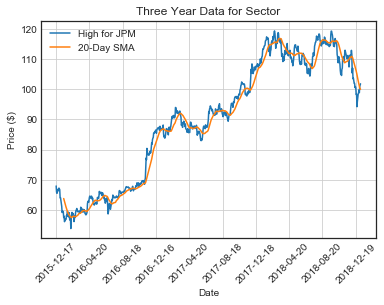

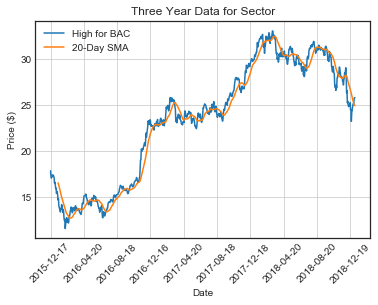

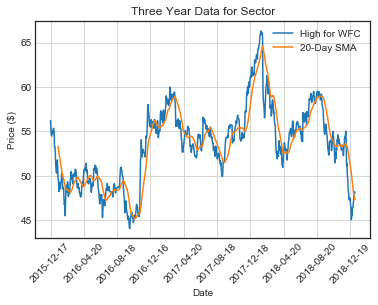

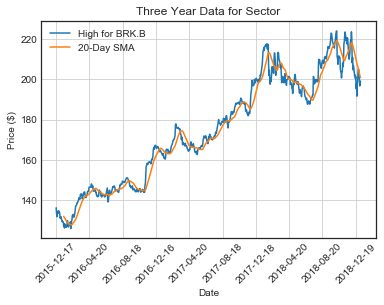

In [9]:
# Create Scatter plots showing price variation of stocks during a 3 year period
# Will need to manually change the value of i in order to get stocks for each company

# initialize working data frame
ts_df = pd.DataFrame({'A' : []})

# Due to API request limitations, function definitions are provided bellow in order more easily produce plots
# Returns cleaned historical data in the form of a data frame
def manipulation (ts_df):
    # create a data frame from the json
    timeseries_df = ts_df = pd.DataFrame.from_dict(json_responses[j]["Time Series (Daily)"])
    # rename the index to actually be accurate.
    ts_df.index.name = "Date"
    # only look at data from the past 3 years 
    ts_df = ts_df.T.head(810)
    # sort so that the dates go from 2016 to 2019 instead of the reverse
    ts_df = ts_df.loc[::-1,:]
    ts_df = ts_df.head(769)
    # Rename columns
    # create the dictionary to pass to the rename method.
    re_col = {"1. open": "Open", "2. high": "High", "3. low": "Low",\
              "4. close": "Close", "5. volume": "Volume"}
    ts_df = ts_df.rename(columns = re_col)
    return ts_df

# calculate simple moving average to provide more rounded time series 
def SMA(ts_df):
    ts_df = manipulation(ts_df)
    ts_df["20 Day SMA"] = ts_df["High"].rolling(window=20).mean()
    return (ts_df)


# Create Visualization
def visualization (ts_df,i,j):
    colors = ["red","green","blue","orange"]
    ts_df = SMA(ts_df)
    # create data arrays
    index = list(ts_df.index)
    vis_df = pd.DataFrame({f"High for {symbols[i][j]}":ts_df["High"],\
                           "20-Day SMA":ts_df["20 Day SMA"]}, index = index)
    vis_df = vis_df.astype(float)
    # plot
    plt.style.use('seaborn-white')
    vis_df.plot(grid=True,title=f'Three Year Data for Sector', 
                xticks=([w*7*12 for w in range(10)]),rot=45)
    plt.xlabel("Date")
    plt.ylabel("Price ($)")

# Create plots of each company based on sector parameter i  
while j < 4:
    visualization(ts_df,i,j)
    j+=1

In [10]:
# should only be shown once at the end of notebook
plt.show()             